# MazeDrone with TF Agents - 05 Train and Save Agent

This notebook aims to develop a script capable of saving the agent and its policy, loading it again and  continue training it. 

### Setup

In [1]:
import os
# Keep using keras-2 (tf-keras) rather than keras-3 (keras).
os.environ['TF_USE_LEGACY_KERAS'] = '1'

from __future__ import absolute_import, division, print_function



import matplotlib.pyplot as plt
import numpy as np
import PIL.Image

import tensorflow as tf
from tf_agents.agents.dqn import dqn_agent
from tf_agents.environments import suite_gym
from tf_agents.environments import tf_py_environment
from tf_agents.metrics import tf_metrics
from tf_agents.utils import common

import sys
import gym

2024-10-05 08:15:24.274780: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-05 08:15:24.279530: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-10-05 08:15:24.355027: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-05 08:15:25.519781: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


### Hyperparameters

In [2]:
num_iterations = 2500 # @param {type:"integer"}

initial_collect_steps = 64  # @param {type:"integer"}
collect_steps_per_iteration = 1 # @param {type:"integer"}
#replay_buffer_max_length = 100000  # @param {type:"integer"}
replay_buffer_max_length = 100  # @param {type:"integer"}

batch_size = 64  # @param {type:"integer"}
learning_rate = 1e-3  # @param {type:"number"}
log_interval = 100  # @param {type:"integer"}

num_eval_episodes = 10  # @param {type:"integer"}
eval_interval = 100  # @param {type:"integer"}

rewards = []
# rewards.append({
#     'destroyed': 0.,
#     'stuck': - 50.,
#     'reached': 100.,
#     'standard': -10.
# })
# rewards.append({
#     'destroyed': -60.,
#     'stuck': - 50.,
#     'reached': 100.,
#     'standard': -10.
# })
rewards.append({
    'destroyed': -10.,
    'stuck': - 5.,
    'reached': 10.,
    'standard': -1.
})
# rewards.append({
#     'destroyed': -150.,
#     'stuck': - 50.,
#     'reached': 100.,
#     'standard': -10.
# })

### Environment

In [3]:
sys.path.append('/home/naski/Documents/dev/maze_drone_v02')
import gym_maze # Esta linha precisa estar após o PATH

In [4]:
# Importing custom environment
env_name = 'maze-v0'
env = suite_gym.load(env_name)

# Testing
env.reset()

TimeStep(
{'step_type': array(0, dtype=int32),
 'reward': array(0., dtype=float32),
 'discount': array(1., dtype=float32),
 'observation': array([ 1.       ,  0.       ,  1.       ,  1.       ,  2.828427 ,
       -0.7853982], dtype=float32)})

Usually two environments are instantiated: one for training and one for evaluation.

In [5]:
train_py_env = suite_gym.load(env_name)
# Converts environments, originally in pure Python, to tensors (using a wrapper)
train_env = tf_py_environment.TFPyEnvironment(train_py_env)

## Training Loop

In [6]:
from resources import build_agent, TrainingSession
import pandas as pd
import gc

In [7]:
# Agent fully connected layer params 
fc_layer_params = (200,) 

# print('Combination', combination + 1, ' | Run', run + 1)

# CREATING/RESETING THE AGENT
agent = build_agent(fc_layer_params, env, learning_rate, train_env)
agent.initialize()

# GENERATE TRAINING SESSION
session = TrainingSession(env_name, rewards[0], agent, collect_steps_per_iteration, 
                        num_iterations, eval_interval, replay_buffer_max_length, num_eval_episodes)

# TRAINING
step_log, returns, finished, crashed, stucked, steped, loss_log, replay_buffer = session.train()

# # LOGGING
# df_log = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 'Stuck Counter': stucked, 'Avg Steps/Episode': steped})
# df_log.to_csv(f"logs/01-rewards-combinations/04_comb-{combination+1}-run-{run+1}.csv", index=None, header=True)

# # CLEAR MEMORY
# del(agent)
# del(session)
# del(df_log)
# gc.collect()


Rewards Updated: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Rewards Updated: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Instructions for updating:
Use `as_dataset(..., single_deterministic_pass=False) instead.
Rewards: {'destroyed': -10.0, 'stuck': -5.0, 'reached': 10.0, 'standard': -1.0}
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.foldr(fn, elems, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.foldr(fn, elems))
step = 1000
step = 2000


## Visualization

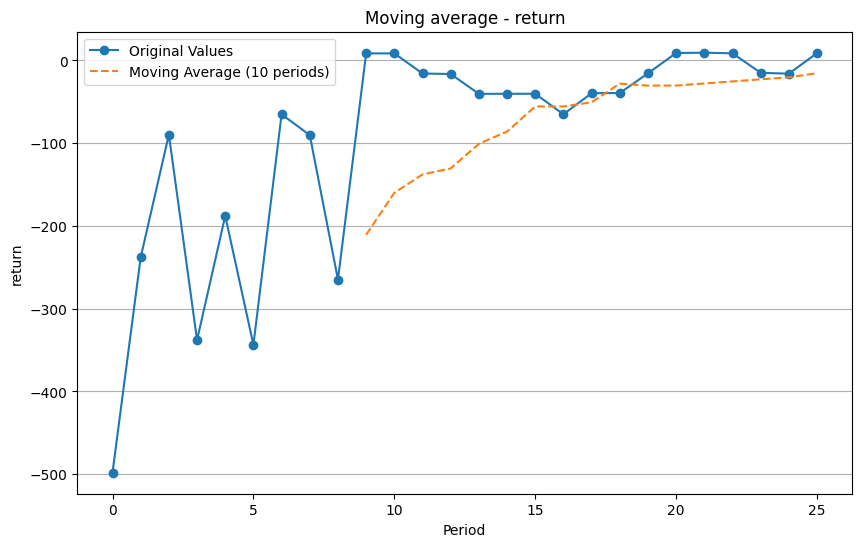

In [8]:
from resources import plot_moving_avg, plot_metric_per_iteration
plot_moving_avg('return', returns)

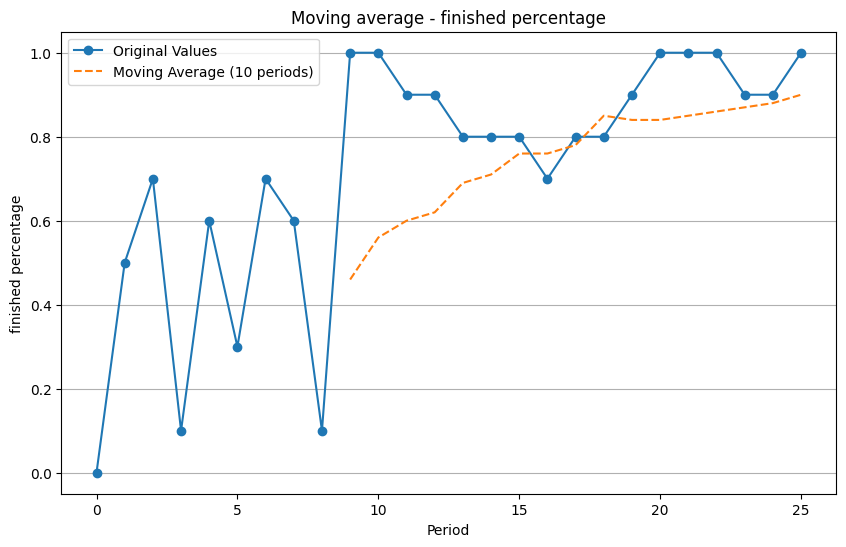

In [9]:
plot_moving_avg('finished percentage', finished)

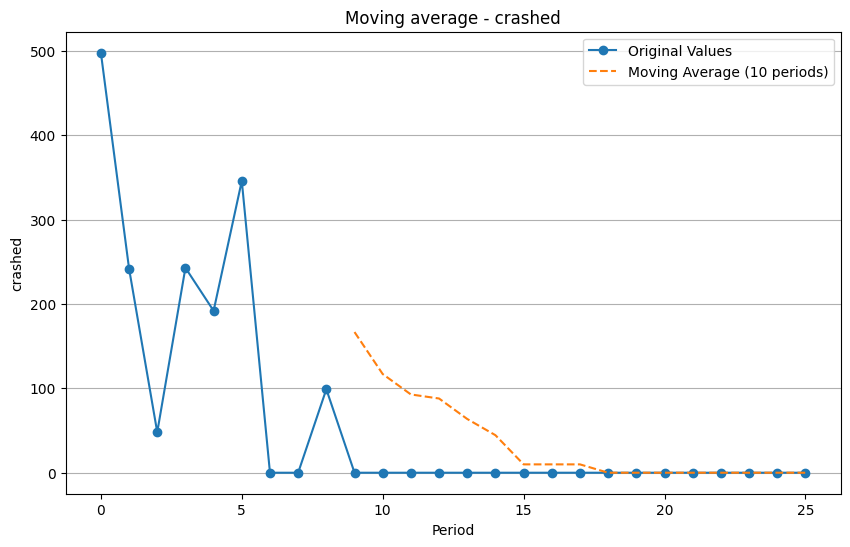

In [12]:
plot_moving_avg('crashed', crashed)

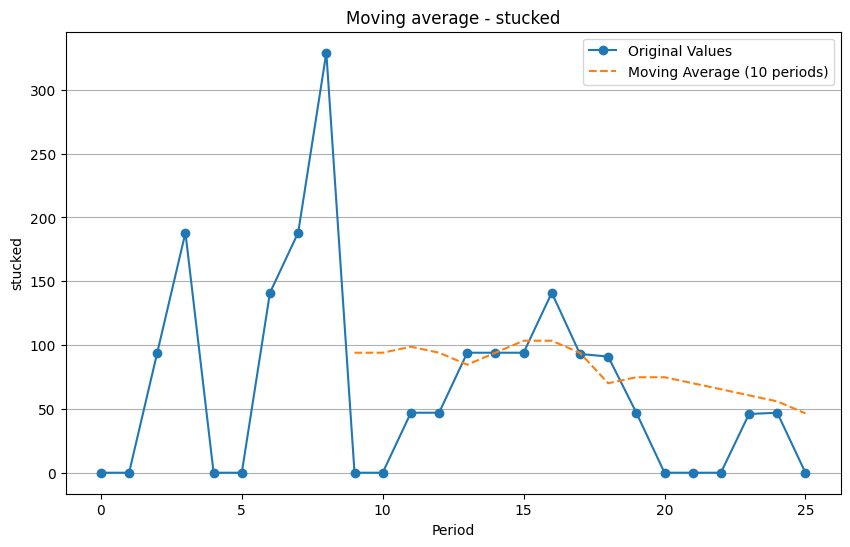

In [13]:
plot_moving_avg('stucked', stucked)

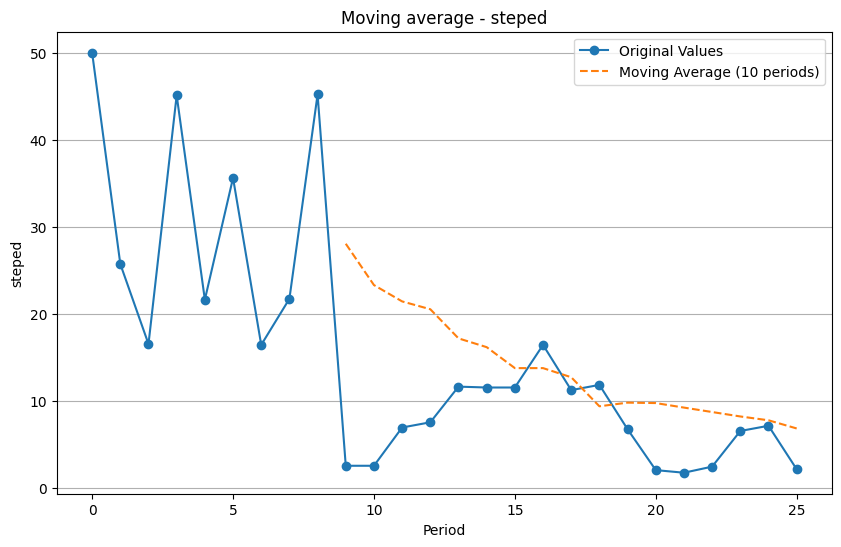

In [14]:
plot_moving_avg('steped', steped)

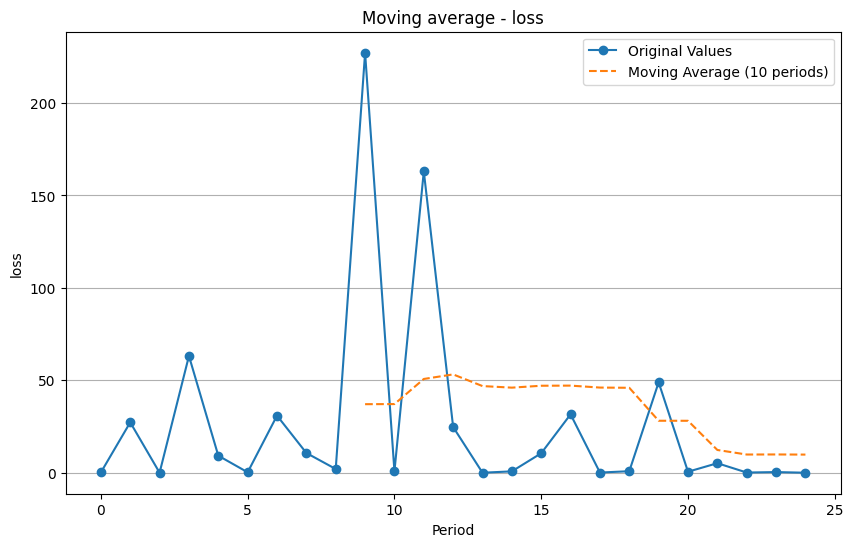

In [16]:
plot_moving_avg('loss', loss_log)

In [22]:
from resources import create_policy_eval_video


# Reset the environment.
time_step = train_py_env.reset()
train_py_env.set_mode(0)


# Gera video da politica do agente treinado até então
create_policy_eval_video(agent.policy, "trained-agent", train_env, train_py_env)

In [18]:
print('global_step:')
print(agent.train_step_counter)

global_step:
<tf.Variable 'Variable:0' shape=() dtype=int32, numpy=2500>


In [19]:
checkpoint_dir = './checkpoint/phase-1-crash'

train_checkpointer = common.Checkpointer(
    ckpt_dir=checkpoint_dir,
    max_to_keep=1,
    agent=agent,
    policy=agent.policy,
    replay_buffer=replay_buffer,
    global_step=agent.train_step_counter
)


In [20]:
train_checkpointer.save(agent.train_step_counter)

In [23]:
import pandas as pd

In [25]:
df_log = pd.DataFrame({'Step': step_log, 'Average Return': returns, '% Finished': finished, 'Crash Counter': crashed, 'Stuck Counter': stucked, 'Avg Steps/Episode': steped, 'Loss log': loss_log})

ValueError: All arrays must be of the same length